# How much is your Fiat 500 worth? 🚗💨 - Price Prediction

<br />

<center>
<img src="https://i0.wp.com/perezloizeau.com/wp-content/uploads/2015/09/Fiat-500-2015_1.jpg?w=630" alt="25746" border="0" width="50%" height="50%">
</center>

## Skills: Python, Web scraping, Geopy, Linear Regression

Download the Jupyter Notebook from [GitHub](https://nico-mori.github.io)

<a id='content' />

## Contents

1. [Introduction](#intro)
2. [Web Scraping](#scraping)
3. [Data Cleansing](#cleansing)
4. [EDA](#eda)
5. [Preprocessing](#processing)

<a id='intro' />

## Introduction
[(back to top)](#content)

The Fiat 500 or cinquecento, is one of the most iconic Italian cars ever produced (there was even one displayed at [New York's Museum of Modern Art](https://www.moma.org/collection/works/220647)). In 2007, 50 years after the original model was lanched, Fiat launched a new generation that has been among the most sold cars in Italy ever since.

The goal of this project is to try to predict how much money is one of this very likable cars worth on the second hand market in Italy depending on different variables such as mileage, year, version and any other ones we are able to get from our data gathering.

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import re
import unidecode
from scipy import stats

from tqdm.notebook import tqdm
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException

import matplotlib.pyplot as plt
import seaborn as sns

<a id='scraping' />

## Web Scraping
[(back to top)](#content)

In [2]:
#Load webdriver
driver = webdriver.Chrome(ChromeDriverManager().install())

#Open page
driver.get('https://www.automobile.it/fiat-500-usate?anno_fino_a=2021&immatricolazione=2007')
time.sleep(4)

#Close location popup
driver.find_element(by=By.XPATH, value='//*[@id="modal"]/div/div/div/div/div[2]/button[1]').click()
time.sleep(2)

#Close cookies popup
driver.find_element(by=By.XPATH, value='//*[@id="onetrust-accept-btn-handler"]').click()
time.sleep(2)



====== WebDriver manager ======
Current google-chrome version is 99.0.4844
Get LATEST chromedriver version for 99.0.4844 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/99.0.4844.51/chromedriver_mac64_m1.zip
Driver has been saved in cache [/Users/nicolamori/.wdm/drivers/chromedriver/mac64_m1/99.0.4844.51]
/var/folders/ql/_b5wc0454s19_35z6z14vp8r0000gn/T/ipykernel_7046/699680229.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


In [3]:
#Empty list and df
temp=[]
df = pd.DataFrame(columns=['Title', 'Province','Condition', 'Month_Year', 'Kms', 'Fuel', 'Transmission', 'Price'])

#Number of pages
npages = int(driver.find_element(by=By.XPATH, value='//*[@id="__next"]/main/div[3]/div/div[3]/div[2]/div[3]/div[1]/button[4]').text)

for h in tqdm(range(npages), position = 0, desc='1st loop'):
    
    temp_df = pd.DataFrame()

    #Title
    titles=driver.find_elements(by=By.XPATH, value='//*[@class="jsx-1035818219 Card__Title font-base"]')
    for title in titles: temp.append(title.text)
    
    temp_df['Title'] = temp
    temp.clear()

    #Province
    provinces=driver.find_elements(by=By.XPATH, value='//*[@class="jsx-1035818219 Card__InfoLocation font-base"]/span')
    for province in provinces: temp.append(province.text)
    
    temp_df['Province'] = temp
    temp.clear()
    
    #Specs
    specs=driver.find_elements(by=By.XPATH, value='//*[@class="jsx-1035818219 Card__InfoTag font-base"]')
    for spec in specs: temp.append(spec.text)
    
    while 'Unico proprietario' in temp: temp.remove('Unico proprietario')
    while '2 Proprietari' in temp: temp.remove('2 Proprietari')
    while '3 Proprietari' in temp: temp.remove('3 Proprietari')
    while '4 Proprietari' in temp: temp.remove('4 Proprietari')
    while 'Più di 4 Proprietari' in temp: temp.remove('Più di 4 Proprietari')
        
    size = len(temp) 
    idx_list = [idx for idx, val in enumerate(temp) if val == 'Usato'] 
    temp = [temp[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 
    del temp[0:0 + 1]
    temp = [i for i in temp if len(i)==5] #Quick fix font-bold
    
    temp_df = pd.concat([temp_df, pd.DataFrame(temp, columns=['Condition', 'Month_Year', 'Kms', 'Fuel', 'Transmission'])], axis=1)
    temp.clear()
    
    #Price
    prices=driver.find_elements(by=By.XPATH, value='//*[@class="jsx-1035818219 font-medium"]')
    for price in prices: temp.append(price.text)
        
    temp_df['Price']=temp
    temp.clear()

    #Append data to df
    df = pd.concat([temp_df, df], axis=0, ignore_index=True)    
    
    #Switch to next page or close
    if h < max(range(npages)):
        driver.find_element(by=By.XPATH, value='//*[@class="jsx-2138479547 font-base xxsmall primary-orange styled"]').click()
        time.sleep(3)
    else: driver.close()
    
  
df.to_csv('fiat500_updated.tsv', sep='\t', index=False)

1st loop:   0%|          | 0/159 [00:00<?, ?it/s]

In [37]:
#Empty list and df
temp = []
df_ = pd.DataFrame(columns=['Title', 'Province','Condition', 'Month_Year', 'Kms', 'Fuel', 'Transmission', 'Price'])

#Number of pages
npages = int(driver.find_element_by_xpath('//*[@id="__next"]/main/div[2]/div/div[4]/div[2]/div[3]/div[1]/button[4]').text)

for h in tqdm(range(npages), position = 0, desc='1st loop'):
    

    #Title and Province
    titles=driver.find_elements_by_xpath('//*[@class="jsx-3257049061 jsx-2759044879"]')
    for title in titles: temp.append(title.text)
    
    del temp[1::3]
    temp = [temp[x:x+2] for x in range(0, len(temp),2)]
    
    #Dataframe and clear list
    part_1 = pd.DataFrame(temp, columns=['Title', 'Province'])  
    temp.clear()
    
    
    #Specs
    specs=driver.find_elements_by_xpath('//*[@class="jsx-3257049061 jsx-2759044879 Card__InfoTag font-base"]')
    for spec in specs: temp.append(spec.text)
    
    while 'Unico proprietario' in temp: temp.remove('Unico proprietario')
    while '2 Proprietari' in temp: temp.remove('2 Proprietari')
    while '3 Proprietari' in temp: temp.remove('3 Proprietari')
    while '4 Proprietari' in temp: temp.remove('4 Proprietari')
        
    size = len(temp) 
    idx_list = [idx for idx, val in enumerate(temp) if val == 'Usato'] 
    temp = [temp[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 
    del temp[0:0 + 1]
    
    #Dataframe and clear list
    part_2 = pd.DataFrame(temp, columns=['Condition', 'Month_Year', 'Kms', 'Fuel', 'Transmission'])
    temp.clear()
    
    
    #Price
    prices=driver.find_elements_by_xpath('//*[@class="jsx-3257049061 jsx-2759044879 Card__InfoPrice font-medium"]')
    for price in prices: temp.append(price.text)
        
    #Dataframe and clear list
    part_3 = pd.DataFrame(temp, columns=['Price'])
    temp.clear()
    
    
    #Combine parts and append to dataframe
    df = pd.concat([part_1.reset_index(drop=True), part_2.reset_index(drop=True), part_3.reset_index(drop=True)], axis=1)
    df_ = df_.append(df, ignore_index = True)
    
    
    #Switch to next page or close
    if h < max(range(npages)):
        driver.find_element_by_xpath('//*[@class="jsx-3190051910 font-base xxsmall primary-orange styled"]').click()
        time.sleep(3)
    else: driver.close()
    
    
#df_.to_csv('fiat500_prices.tsv', sep='\t', index=False)


CPU times: user 26.1 s, sys: 2.32 s, total: 28.4 s
Wall time: 20min 55s


<a id='cleansing' />

## Data Cleansing
[(back to top)](#content)

In [37]:
fiat_500 = df
fiat_500 = fiat_500.dropna().reset_index(drop=True)

In [77]:
fiat_500=pd.read_csv('fiat500_prices.tsv', sep='\t')

fiat_500.head()

,Title,Province,Condition,Month_Year,Kms,Fuel,Transmission,Owners,Price
0,Fiat 500 abarth fiat 500e elettrica abarth pri...,Verona (VR),Usato,Dicembre 2015,29.233 km,Elettrico,Automatico,NaN,€ 9.991
1,FIAT 500,Giugliano in Campania (NA),Usato,Luglio 2013,51.000 km,Benzina - Euro 5,Manuale,NaN,€ 4.990
2,Fiat 500 1.2 69cv Collezione Tetto,Ciampino (RM),Usato,Gennaio 2019,31.412 km,Benzina - Euro 6,Manuale,NaN,€ 9.980
3,FIAT 500 1.2 Lounge,Moncalieri (TO),Usato,Aprile 2019,14.918 km,Benzina - Euro 6,Manuale,NaN,€ 9.900
4,FIAT 500 1.2 Lounge,Torino (TO),Usato,Maggio 2019,18.539 km,Benzina - Euro 6,Manuale,NaN,€ 9.700


In [38]:
conditions = [fiat_500['Title'].str.contains('Lounge', case=False), 
              fiat_500['Title'].str.contains('Pop', case=False), 
              fiat_500['Title'].str.contains('Collezione', case=False), 
              fiat_500['Title'].str.contains('Star', case=False), 
              fiat_500['Title'].str.contains('Sport', case=False), 
              fiat_500['Title'].str.contains('S ', case=False), 
              fiat_500['Title'].str.contains(' S', case=False),  
              fiat_500['Title'].str.contains('"S"', case=False)]

choices = ['Lounge', 'Pop', 'Collezione', 'Star', 'Sport', 'Sport', 'Sport', 'Sport']

fiat_500['Version'] = np.select(conditions, choices, default='None')

In [39]:
fiat_500['Kms'] = [str(i).replace(' km','') for i in fiat_500['Kms']]
fiat_500['Kms'] = pd.to_numeric(fiat_500['Kms'])*1000

fiat_500['Price'] = [i.replace('€ ','') for i in fiat_500['Price']]
fiat_500['Price'] = pd.to_numeric(fiat_500['Price'])*1000

fiat_500['Fuel'] = [i.replace(' - Euro ','') for i in fiat_500['Fuel']]
fiat_500['Fuel'] = fiat_500['Fuel'].str.replace('\d+', '', regex=True)

fiat_500['Year'] = fiat_500['Month_Year'].str.strip().str[-4:]
fiat_500['Year'] = pd.to_numeric(fiat_500['Year'])

In [40]:
provinces = pd.read_csv('it_provinces.csv', sep=';',  keep_default_na=False)

fiat_500['Province'] = fiat_500['Province'].str.strip().str[-3:-1]
fiat_500 = fiat_500.merge(provinces, on='Province', how='left')

In [41]:
fiat_500 = fiat_500[~fiat_500['Title'].str.contains('Abarth', case=False)]
fiat_500 = fiat_500[~fiat_500['Title'].str.contains('C ', case=False)]
fiat_500 = fiat_500[fiat_500['Version']!='None']

fiat_500.drop(['Month_Year', 'Condition', 'Province', 'Name', 'Title'], axis=1)

#fiat_500=fiat_500.drop_duplicates()

fiat_500.head()

#Verificare risultato finale

,Title,Province,Condition,Month_Year,Kms,Fuel,Transmission,Price,Version,Year,Name,Region
0,FIAT 500 1.2 Lounge OK NEOPATENTATI,PU,Usato,Aprile 2011,150000.0,Benzina,Manuale,7700.0,Lounge,2011,Pesaro e Urbino,Marche
1,FIAT 500 1.2 Lounge,AR,Usato,Giugno 2017,47000.0,Benzina,Manuale,12600.0,Lounge,2017,Arezzo,Toscana
4,FIAT 500 1.3 Multijet 16V 95 CV Lounge,PG,Usato,Marzo 2011,191400.0,Diesel,Manuale,7800.0,Lounge,2011,Perugia,Umbria
5,FIAT 500 500 1.3 MJT 75 CV Lounge Bianco Perla,PU,Usato,Febbraio 2009,180000.0,Diesel,Manuale,6999.0,Lounge,2009,Pesaro e Urbino,Marche
6,FIAT 500 1.2 Sport Cambio Automatico DFN Blue&Me,TA,Usato,Febbraio 2009,132670.0,Benzina,Automatico,6890.0,Sport,2009,Taranto,Puglia


<a id='eda' />

## EDA
[(back to top)](#content)

In [82]:
fiat_500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 2 to 3148
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Kms           2489 non-null   float64
 1   Fuel          2489 non-null   object 
 2   Transmission  2483 non-null   object 
 3   Price         2489 non-null   float64
 4   Version       2489 non-null   object 
 5   Year          2489 non-null   int64  
 6   Region        2488 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 155.6+ KB


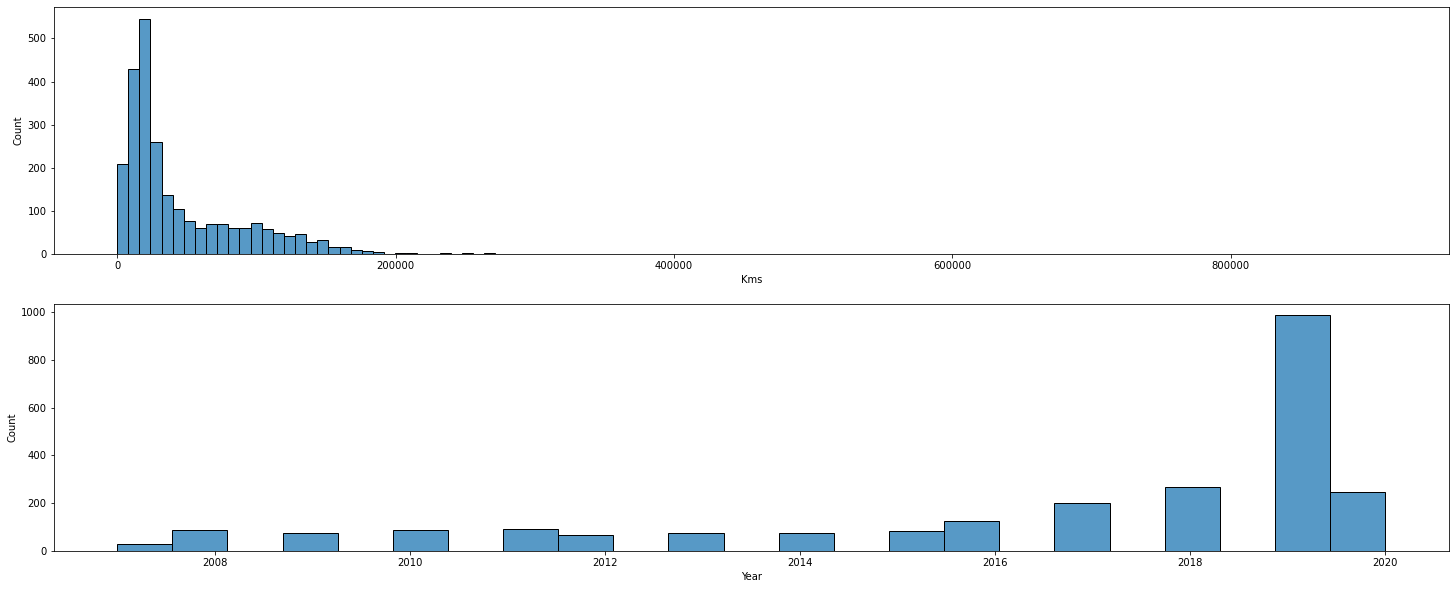

In [87]:
#Distribucion en variables numericas
temp = fiat_500.drop('Price', axis=1).select_dtypes(['int64','float64'])

fig, axes = plt.subplots(2,1, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp.columns):
    sns.histplot(data=temp[i], ax=axes[h])

<AxesSubplot:>

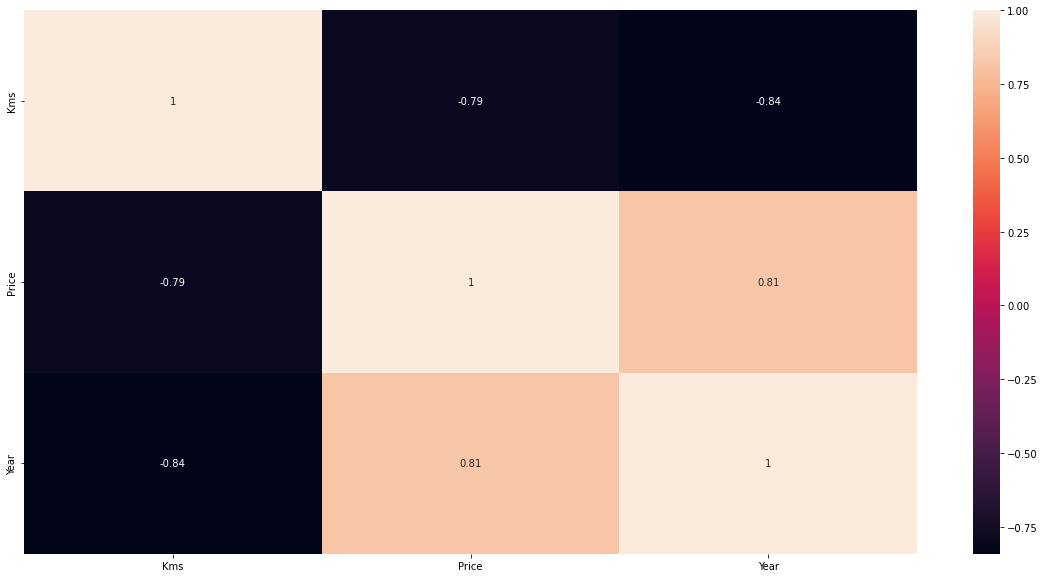

In [89]:
#Correlacion entre variables numericas y variable objetivo
plt.figure(figsize=(20, 10))
sns.heatmap(fiat_500.select_dtypes(['int64','float64']).corr(method='spearman'), annot = True)

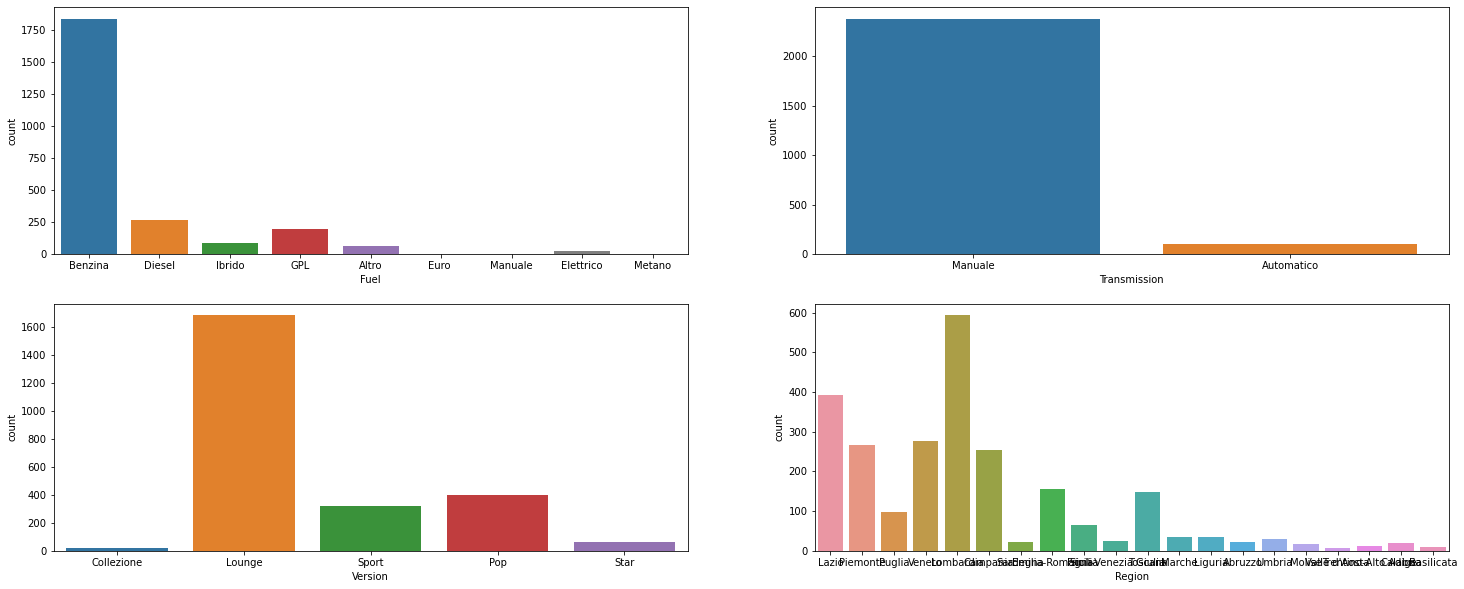

In [90]:
#Distribucion en variables categoricas
temp = fiat_500.select_dtypes('object')

fig, axes = plt.subplots(2,2, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp.columns):
    sns.countplot(data=temp, x=i, ax=axes[h])

<a id='processing' />

## Preprocessing
[(back to top)](#content)

In [9]:
fiat_500 = fiat_500[(np.abs(stats.zscore(fiat_500[['Price','Kms']])) < 4).all(axis=1)].reset_index(drop=True)

In [10]:
# split into X and Y
X = fiat_500.loc[:, fiat_500.columns != 'Price']
Y = fiat_500.loc[:, fiat_500.columns == 'Price']

In [11]:
# creating dummy variables for categorical variables
fiat_categorical = X.select_dtypes(include=['object'])

fiat_dummies = pd.get_dummies(fiat_categorical, drop_first=True)

In [13]:
# drop categorical variables 
X = X.drop(list(fiat_categorical.columns), axis=1)

# concat dummy variables with X
X = pd.concat([X, fiat_dummies], axis=1)

In [15]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['Kms', 'Fuel_Benzina', 'Fuel_Diesel', 'Fuel_Elettrico', 'Fuel_Euro ',
       'Fuel_GPL', 'Fuel_Ibrido', 'Fuel_Manuale', 'Fuel_Metano',
       'Transmission_Manuale', 'Version_Lounge', 'Version_Pop',
       'Version_Sport', 'Version_Star', 'Year_2008', 'Year_2009', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Year_2019', 'Year_2020',
       'Region_Basilicata', 'Region_Calabria', 'Region_Campania',
       'Region_Emilia-Romagna', 'Region_Friuli-Venezia Giulia', 'Region_Lazio',
       'Region_Liguria', 'Region_Lombardia', 'Region_Marche', 'Region_Molise',
       'Region_Piemonte', 'Region_Puglia', 'Region_Sardegna', 'Region_Sicilia',
       'Region_Toscana', 'Region_Trentino-Alto Adige', 'Region_Umbria',
       'Region_Valle d'Aosta', 'Region_Veneto'],
      dtype='object')

In [20]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [22]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [23]:
# Building the first model with all the features

# instantiate
lm = LinearRegression()

# fit
lm.fit(X_train, y_train)

LinearRegression()

In [24]:
# print coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[[-7.61928197e+02 -6.11170081e+02 -1.28563695e+02 -1.12056244e+02
  -4.00785360e+01 -2.50900406e+02 -1.50074697e+02 -5.52005454e+01
  -2.80640348e+01 -1.59605540e+02 -8.15248264e+01 -3.28689422e+02
   1.51072402e+02  1.25009428e+02  1.35979725e+02  1.28542826e+02
   2.33670005e+02  2.61766926e+02  2.71500316e+02  4.00243494e+02
   4.14229718e+02  5.25845735e+02  7.13392244e+02  1.11923416e+03
   1.23949624e+03  2.17134026e+03  1.85313887e+03  3.88690431e+01
  -2.04481491e+01 -1.84178926e+02 -1.31619970e+01 -6.79583895e+00
  -2.25862991e+02 -3.44577860e+01 -9.84923675e+01  3.55606031e+00
  -1.32403671e+02 -1.25569984e+02 -1.83934495e+01  6.18769053e+01
   1.52905097e+00  3.87237145e+00  3.57363309e+01  8.84905428e+01
  -1.68986614e+01 -1.22520067e+02]]
[9491.02229203]


In [25]:
# predict 
y_pred = lm.predict(X_test)

# metrics
from sklearn.metrics import r2_score

print(r2_score(y_true=y_test, y_pred=y_pred))

0.8708753205620077


In [ ]:
#https://towardsdatascience.com/predicting-car-price-using-machine-learning-8d2df3898f16